# Dishwasher eco mode analysis

## Imports and setup


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime
import scipy.integrate
from pint import UnitRegistry, Quantity
import os

# Initialize unit registry
ureg = UnitRegistry()

FILE_FORMAT = "svg"

DARK_MODE = False
if DARK_MODE:
    plt.style.use("dark_background")
    plt.rcParams["figure.facecolor"] = "#040711"  # Figure background
    plt.rcParams["axes.facecolor"] = "#040711"  # Axes background
else:
    plt.style.use("default")
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["axes.facecolor"] = "white"

# Define paths
data_path = "data"
plots_dir = "plots/dark" if DARK_MODE else "plots/light"
plots_path = Path(data_path) / ".." / plots_dir
if DARK_MODE:
    plots_path = plots_path
os.makedirs(plots_path, exist_ok=True)

## Data classes


In [8]:
@dataclass
class DataPoint:
    state: float
    last_changed: datetime
    seconds_elapsed: float

## Load data, filter data, construct objects


In [9]:
modes = ["eco", "eco_quick"]
entity_id = "sensor.elmatare_diskmaskin_power"
START_STOP_THRESHOLD = 1.0  # Watts, below which we consider the machine to be off in the beginning and end of the data

data_points: dict[str, list[DataPoint]] = {mode: [] for mode in modes}

for mode in modes:
    raw_data = np.loadtxt(Path(data_path) / f"history-{mode}.csv", skiprows=1, delimiter=",", dtype=str)

    for row in [x for x in raw_data if x[0] == entity_id]:
        state = float(row[1])
        # If power is less than START_STOP_THRESHOLD and we dont have any datapoint yet,
        # skip it in order to get a time of 0 when starting
        if state < START_STOP_THRESHOLD and len(data_points[mode]) == 0:
            print(
                f"Skipping {row[0]} with state {state} and last_changed {row[2]} for {mode}, as no previous data points exist with non-neglible power"
            )
            continue

        last_changed = datetime.fromisoformat(row[2].replace("Z", "+00:00"))
        if len(data_points[mode]):
            seconds_elapsed = (last_changed - data_points[mode][0].last_changed).total_seconds()
        else:
            seconds_elapsed = 0
        data_points[mode].append(DataPoint(state, last_changed, seconds_elapsed))

    # Remove all trailing data points with state 0, excelt for the last one
    while (
        data_points[mode]
        and len(data_points[mode]) >= 2
        and data_points[mode][-1].state <= START_STOP_THRESHOLD
        and data_points[mode][-2].state <= START_STOP_THRESHOLD
    ):
        print(
            f"Removing trailing data point with state {data_points[mode][-1].state} for {mode} at {data_points[mode][-1].last_changed}"
        )
        data_points[mode].pop()

Skipping sensor.elmatare_diskmaskin_power with state 0.0 and last_changed 2025-05-20T16:00:00.000Z for eco, as no previous data points exist with non-neglible power
Skipping sensor.elmatare_diskmaskin_power with state 0.0 and last_changed 2025-05-18T13:00:00.000Z for eco_quick, as no previous data points exist with non-neglible power
Skipping sensor.elmatare_diskmaskin_power with state 0.1 and last_changed 2025-05-18T14:07:15.611Z for eco_quick, as no previous data points exist with non-neglible power
Skipping sensor.elmatare_diskmaskin_power with state 0.0 and last_changed 2025-05-18T14:07:20.667Z for eco_quick, as no previous data points exist with non-neglible power
Removing trailing data point with state 0.0 for eco_quick at 2025-05-18 16:09:57.891000+00:00
Removing trailing data point with state 0.1 for eco_quick at 2025-05-18 16:09:52.928000+00:00
Removing trailing data point with state 0.0 for eco_quick at 2025-05-18 16:02:30.574000+00:00
Removing trailing data point with state 

## Create visualizations


/var/folders/g0/n924lncn6ssb4gn34qs428gc0000gn/T/ipykernel_26918/1850050661.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


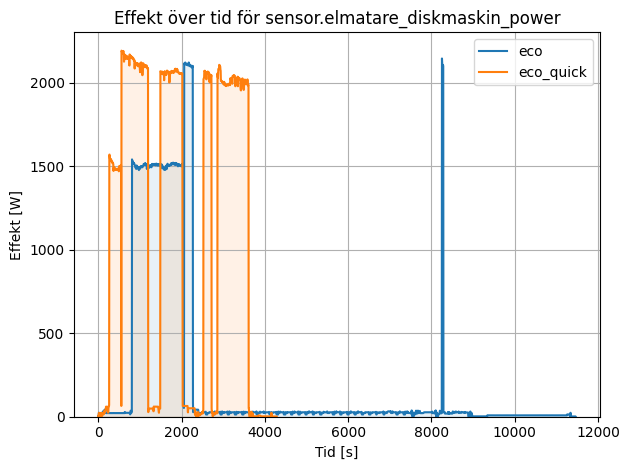

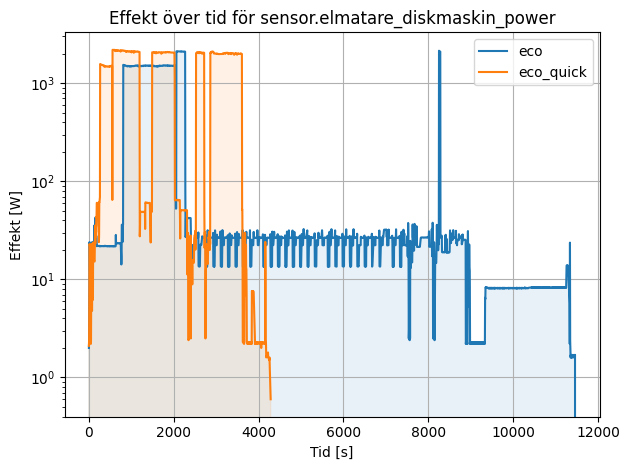

In [10]:
# Power vs time
for mode in modes:
    x = [x.seconds_elapsed for x in data_points[mode]]
    y = [x.state for x in data_points[mode]]

    plt.figure(0)
    plt.plot(x, y, label=mode)

    # Fill between with the color of the line
    plt.fill_between(x=x, y1=y, color=plt.gca().lines[-1].get_color(), alpha=0.1)

    plt.figure(1)
    plt.semilogy(x, y, label=mode)

    # Fill between with the color of the line
    plt.fill_between(x=x, y1=y, color=plt.gca().lines[-1].get_color(), alpha=0.1)


for figure_idx in [0, 1]:
    plt.figure(figure_idx)
    plt.ylim(bottom=0)
    plt.legend()
    plt.xlabel("Tid [s]")
    plt.ylabel("Effekt [W]")
    plt.title(f"Effekt över tid för {entity_id}")
    plt.tight_layout()
    plt.grid()
    plt.savefig(
        plots_path / f"power_vs_time_{entity_id}_{figure_idx}.{FILE_FORMAT}", facecolor=plt.gcf().get_facecolor()
    )

Total energy consumed in eco mode: 0.71 kilowatt_hour
Elapsed time (hh:mm) in eco mode: 03:11 (or 11465 seconds)
Total energy consumed in eco_quick mode: 1.35 kilowatt_hour
Elapsed time (hh:mm) in eco_quick mode: 01:11 (or 4285 seconds)


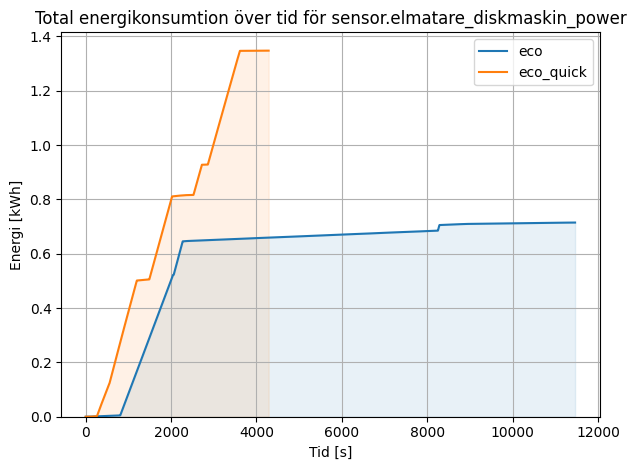

In [11]:
# Energy vs time

# dicts for total energy and energy when heating
total_energy: dict[str, Quantity] = {}

for mode in modes:
    # Integrate the power over time to get the energy consumed
    energy_joule = scipy.integrate.cumulative_trapezoid(
        [x.state for x in data_points[mode]],
        [x.seconds_elapsed for x in data_points[mode]],
        initial=0,
    )  # [J]

    # Convert to kWh
    energy_kwh = energy_joule / 3.6e6  # [kWh]

    total_energy[mode] = energy_kwh[-1] * ureg.kWh
    print(f"Total energy consumed in {mode} mode: {total_energy[mode]:.2f}")

    elapsed_time = data_points[mode][-1].seconds_elapsed
    elapsed_time_hhmm = f"{int(elapsed_time // 3600):02}:{int((elapsed_time % 3600) // 60):02}"
    print(f"Elapsed time (hh:mm) in {mode} mode: {elapsed_time_hhmm} (or {elapsed_time:.0f} seconds)")

    x = [x.seconds_elapsed for x in data_points[mode]]
    y = energy_kwh

    plt.figure(2)
    plt.plot(x, y, label=mode)

    # Fill between with the color of the line
    plt.fill_between(x=x, y1=y, color=plt.gca().lines[-1].get_color(), alpha=0.1)

plt.ylim(bottom=0)
plt.legend()
plt.xlabel("Tid [s]")
plt.ylabel("Energi [kWh]")
plt.title(f"Total energikonsumtion över tid för {entity_id}")
# set log-y plot
plt.tight_layout()
plt.grid()
plt.savefig(plots_path / f"energy_vs_time_{entity_id}.{FILE_FORMAT}", facecolor=plt.gcf().get_facecolor())

## Calculate water usage


In [12]:
initial_temperature = 10 * ureg.delta_degC

final_temperatures: dict[str, Quantity] = {
    "eco": 50 * ureg.delta_degC,
    "eco_quick": 50 * ureg.delta_degC,
}

# Calculate the mass of water in the dishwasher based on the energy consumed
mass_water = {}

for mode in modes:
    # Calculate the mass of water in the dishwasher based on the energy consumed
    # Q = mcΔT
    # m = Q / (cΔT)
    # where Q is the energy consumed, c is the specific heat capacity of water (4.186 J/g°C),
    # and ΔT is the change in temperature (final - initial)
    delta_T = final_temperatures[mode] - initial_temperature

    c_water = 4.186 * ureg.J / (ureg.g * ureg.delta_degC)  # specific heat capacity of water

    mass_water[mode] = (total_energy[mode] / (c_water * delta_T)).to(ureg.kg)  # convert to kg

    print(f"Mass of water in {mode} mode: {mass_water[mode]:.2f} (temperature change: {delta_T})")

Mass of water in eco mode: 15.36 kilogram (temperature change: 40 delta_degree_Celsius)
Mass of water in eco_quick mode: 28.97 kilogram (temperature change: 40 delta_degree_Celsius)
